# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [ ]:
import random
import numpy as np
import pickle
import os
# from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [ ]:
# from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = '/content'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((49000, 32, 32, 3),
 (49000,),
 (1000, 32, 32, 3),
 (1000,),
 (1000, 32, 32, 3),
 (1000,))

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [ ]:
## Utilities functions
import matplotlib
import numpy as np
from scipy.ndimage import uniform_filter


def extract_features(imgs, feature_fns, verbose=False):
    """
    Given pixel data for images and several feature functions that can operate on
    single images, apply all feature functions to all images, concatenating the
    feature vectors for each image and storing the features for all images in
    a single matrix.

    Inputs:
    - imgs: N x H X W X C array of pixel data for N images.
    - feature_fns: List of k feature functions. The ith feature function should
      take as input an H x W x D array and return a (one-dimensional) array of
      length F_i.
    - verbose: Boolean; if true, print progress.

    Returns:
    An array of shape (N, F_1 + ... + F_k) where each column is the concatenation
    of all features for a single image.
    """
    num_images = imgs.shape[0]
    if num_images == 0:
        return np.array([])

    # Use the first image to determine feature dimensions
    feature_dims = []
    first_image_features = []
    for feature_fn in feature_fns:
        feats = feature_fn(imgs[0].squeeze())
        assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
        feature_dims.append(feats.size)
        first_image_features.append(feats)

    # Now that we know the dimensions of the features, we can allocate a single
    # big array to store all features as columns.
    total_feature_dim = sum(feature_dims)
    imgs_features = np.zeros((num_images, total_feature_dim))
    imgs_features[0] = np.hstack(first_image_features).T

    # Extract features for the rest of the images.
    for i in range(1, num_images):
        idx = 0
        for feature_fn, feature_dim in zip(feature_fns, feature_dims):
            next_idx = idx + feature_dim
            imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
            idx = next_idx
        if verbose and i % 1000 == 0:
            print('Done extracting features for %d / %d images' %
                  (i, num_images))

    return imgs_features


def rgb2gray(rgb):
    """Convert RGB image to grayscale

      Parameters:
        rgb : RGB image

      Returns:
        gray : grayscale image

    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.144])


def hog_feature(im):
    """Compute Histogram of Gradient (HOG) feature for an image

         Modified from skimage.feature.hog
         http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog

       Reference:
         Histograms of Oriented Gradients for Human Detection
         Navneet Dalal and Bill Triggs, CVPR 2005

      Parameters:
        im : an input grayscale or rgb image

      Returns:
        feat: Histogram of Gradient (HOG) feature

    """

    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape  # image size
    orientations = 9  # number of gradient bins
    cx, cy = (8, 8)  # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1)  # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0)  # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2)  # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * \
        (180 / np.pi) + 90  # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:, :, i] = uniform_filter(temp_mag, size=(cx, cy))[cx//2::cx, cy//2::cy].T

    return orientation_histogram.ravel()


def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
    """
    Compute color histogram for an image using hue.

    Inputs:
    - im: H x W x C array of pixel data for an RGB image.
    - nbin: Number of histogram bins. (default: 10)
    - xmin: Minimum pixel value (default: 0)
    - xmax: Maximum pixel value (default: 255)
    - normalized: Whether to normalize the histogram (default: True)

    Returns:
      1D vector of length nbin giving the color histogram over the hue of the
      input image.
    """
    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin+1)
    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    imhist, bin_edges = np.histogram(
        hsv[:, :, 0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)

    # return histogram
    return imhist

In [ ]:
# from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [ ]:
import numpy as np

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = len(y)     # number of samples
    Y_hat = X @ W  # raw scores matrix

    y_hat_true = Y_hat[range(N), y][:, np.newaxis]    # scores for true labels
    margins = np.maximum(0, Y_hat - y_hat_true + 1)   # margin for each score
    loss = margins.sum() / N - 1 + reg * np.sum(W**2) # regularized loss

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    dW = (margins > 0).astype(int)    # initial gradient with respect to Y_hat
    dW[range(N), y] -= dW.sum(axis=1) # update gradient to include correct labels
    dW = X.T @ dW / N + 2 * reg * W   # gradient with respect to W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        # assume y takes values 0...K-1 where K is number of classes
        num_classes = np.max(y) + 1
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            batch_indices = np.random.choice(
                num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate * grad


            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [ ]:
# from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.geomspace(1e-4, 1e-2, 3)
regularization_strengths = np.geomspace(0.01, 1, 3)

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create SVM and train it
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, lr, reg, num_iters=1500)

    # Compute training and validation sets accuracies and append to the dictionary
    y_train_pred, y_val_pred = svm.predict(X_train_feats), svm.predict(X_val_feats)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-04 reg 1.000000e-02 train accuracy: 0.451000 val accuracy: 0.440000
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 0.451408 val accuracy: 0.444000
lr 1.000000e-04 reg 1.000000e+00 train accuracy: 0.449755 val accuracy: 0.446000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.502306 val accuracy: 0.490000
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.500265 val accuracy: 0.489000
lr 1.000000e-03 reg 1.000000e+00 train accuracy: 0.483878 val accuracy: 0.470000
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 0.508612 val accuracy: 0.490000
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 0.503327 val accuracy: 0.485000
lr 1.000000e-02 reg 1.000000e+00 train accuracy: 0.478327 val accuracy: 0.476000
best validation accuracy achieved: 0.490000


In [ ]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.48


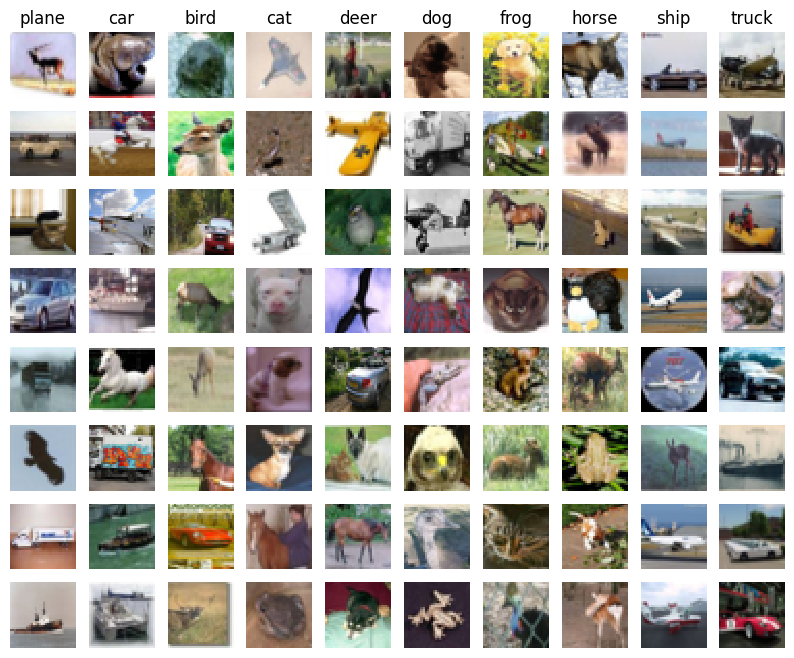

In [ ]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [ ]:
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def linear_backward(self, dout, cache):
        """
        Computes the backward pass for a linear layer.

        Inputs:
        - dout: Gradient of the loss with respect to the output, of shape (N, M).
        - cache: Tuple of (X, W, b) from the forward pass.

        Returns:
        - dX: Gradient of the loss with respect to the input X, of shape (N, D).
        - dW: Gradient of the loss with respect to the weights W, of shape (D, M).
        - db: Gradient of the loss with respect to the biases b, of shape (M,).
        """
        X, W, b = cache
        dx = dout.dot(W.T)
        dw = X.T.dot(dout)
        db = np.sum(dout, axis=0)
        return dx, dw, db

    def linear(self, X, W, b):
        out = X.dot(W) + b
        cache = (X, W, b)
        return out, cache

    def relu_forward(self, x):
        out = np.maximum(0, x)
        return out, x

    def relu_back(self, dout, cache):
        dx = None
        x = cache
        dx = dout * (x > 0)
        return dx

    def softmax_loss(self, x, y):
        """
        Computes the loss and gradient for softmax classification.

        Inputs:
        - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
          class for the ith input.
        - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
          0 <= y[i] < C

        Returns a tuple of:
        - loss: Scalar giving the loss
        - dx: Gradient of the loss with respect to x
        """
        loss, dx = None, None
        ###########################################################################
        # TODO: Implement the loss and gradient for softmax classification. This  #
        # will be similar to the softmax loss vectorized implementation in        #
        # cs231n/classifiers/softmax.py.                                          #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        N = len(y)  # number of samples

        # numerically stable exponents
        P = np.exp(x - x.max(axis=1, keepdims=True))
        # row-wise probabilities (softmax)
        P /= P.sum(axis=1, keepdims=True)

        loss = -np.log(P[range(N), y]).sum() / N  # sum cross entropies as loss

        P[range(N), y] -= 1
        dx = P / N

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ###########################################################################
        #                             END OF YOUR CODE                            #
        ###########################################################################
        return loss, dx

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        scores, cache1 = self.linear(X, W1, b1)
        scores, cache2 = self.relu_forward(scores)
        scores, cache3 = self.linear(scores, W2, b2)
        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss. So that your results match ours, multiply the            #
        # regularization loss by 0.5                                                #
        #############################################################################
        #############################################################################
        loss, dloss = self.softmax_loss(scores, y)
        loss += 0.5 * reg * (np.sum(W1**2) + np.sum(W2**2))

        #############################################################################

        # Backward pass: compute gradients
        grads = {}
        dout3, dw2, db2 = self.linear_backward(dloss, cache3)
        dout2 = self.relu_back(dout3, cache2)
        dout1, dw1, db1 = self.linear_backward(dout2, cache1)

        dw1 += reg * W1
        dw2 += reg * W2

        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        #############################################################################
        grads = {'W1': dw1, 'b1': db1, 'W2': dw2, 'b2': db2}

        #############################################################################

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            #########################################################################
            batch_indices = np.random.choice(
                num_train, batch_size, replace=True)
            X_batch, y_batch = X[batch_indices], y[batch_indices]
            #########################################################################

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            #########################################################################
            for param_name in self.params:
                self.params[param_name] -= learning_rate * grads[param_name]
            #########################################################################

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        scores = self.loss(X, y=None)
        y_pred = np.argmax(scores, axis=1)
        ###########################################################################

        ###########################################################################
        ###########################################################################

        return y_pred

In [ ]:
# from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

# Define ranges for hyperparameter search
hidden_size = 200
learning_rates = np.linspace(1e-2, 2.75e-2, 4)
regularization_strengths = np.geomspace(1e-6, 1e-4, 3)
batch_size = 400

# Dictionary to store results
results = {}
best_val_acc = -1
best_net = None

input_size = 32 * 32 * 3
num_classes = 10


print("Starting hyperparameter search...")

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"Training with hidden_size: {hidden_size}, lr: {lr}, reg: {reg}, batch_size: {batch_size}")
        # Train network
        model = net
        stats = model.train(
            X_train_feats, y_train, X_val_feats, y_val,
            num_iters=3000,  # Increased number of iterations
            batch_size=batch_size,
            learning_rate=lr,
            learning_rate_decay=0.95,
            reg=reg,
            verbose=False
        )

        # Evaluate on validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()

        # Store results
        results[(hidden_size, lr, reg, batch_size)] = val_acc

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_net = net

        print(f"Validation accuracy: {val_acc}")



Starting hyperparameter search...
Training with hidden_size: 200, lr: 0.01, reg: 1e-06, batch_size: 400
Validation accuracy: 0.269
Training with hidden_size: 200, lr: 0.01, reg: 1e-05, batch_size: 400
Validation accuracy: 0.44
Training with hidden_size: 200, lr: 0.01, reg: 0.0001, batch_size: 400
Validation accuracy: 0.494
Training with hidden_size: 200, lr: 0.015833333333333335, reg: 1e-06, batch_size: 400
Validation accuracy: 0.516
Training with hidden_size: 200, lr: 0.015833333333333335, reg: 1e-05, batch_size: 400
Validation accuracy: 0.528
Training with hidden_size: 200, lr: 0.015833333333333335, reg: 0.0001, batch_size: 400
Validation accuracy: 0.539
Training with hidden_size: 200, lr: 0.021666666666666667, reg: 1e-06, batch_size: 400
Validation accuracy: 0.565
Training with hidden_size: 200, lr: 0.021666666666666667, reg: 1e-05, batch_size: 400
Validation accuracy: 0.585
Training with hidden_size: 200, lr: 0.021666666666666667, reg: 0.0001, batch_size: 400
Validation accuracy: 0

In [ ]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.595


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!